### <ins>Imports/Installs</ins>


#### Required package installs

In [521]:
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install xgboost
# !pip install m2cgen

#### Import required libs

In [522]:
import pandas as pd

import matplotlib.pyplot as pyplot

from sklearn import metrics
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#### Defining paths

In [523]:
datasetsPath = '../datasets/gyro/'

#### Importing Dataset.csv

In [524]:
gyro = pd.read_csv(datasetsPath + 'gyro_mobile.csv')

#### Inspecting The Dataset

In [525]:
def printSummaryStatistics():   # Prints statistical for each column in the dataframe
    gyroCols = gyro.columns.to_list()
    for col in gyroCols:
        print(f"Column: {col} \n{gyro[col].describe()} \nData Type: {gyro[col].dtype}\n")


Insights:
- 31991 data points
- Every feature is continuous
- Activity is either 1 or 0 (binary classification)
- Dataset contains a timestamp that might be dropped

### <ins>Data Preprocessing and Training</ins>

#### Dropping timestamp and splitting data into Training, Testing and Eval

In [526]:
gyro = gyro.drop(columns='timestamp')

xtrain, xtest, ytrain, ytest = train_test_split(
    gyro.iloc[:,:6],
    gyro.iloc[:,6:],
    test_size=0.2,
    random_state=0
)

evaldata=[(xtrain,ytrain),(xtest,ytest)]          # Datensatz zur Evaluierung

#### Training and Improving<br>
Um eine gute Anzahl an Estimators zu bestimmen, wird zuerst ein Modell mithilfe von Early Stopping, sowie einer großen Menge an Estimatoren trainiert. Hiermit wird die beste Anzahl an Iterationen ermittelt und mit dieser Anzahl ein weiteres Modell trainiert.

In [527]:
preModel = XGBClassifier(           # "Spendermodell"
    objective='binary:logistic',
    n_estimators=10000,             # "Große Anzahl an Schaetzern, die nicht erreicht werden soll"
    early_stopping_rounds=20,       # Anzahl an Runden, bei denen sich das Modell nicht verbessern muss, bis abgebrochen wird
    max_depth=2,
    learning_rate=0.1
)

preModel.fit(
    xtrain, 
    ytrain, 
    eval_set=evaldata, 
    verbose=False
)

bIter = preModel.best_iteration     # Beste Anzahl an Estimatoren

model = XGBClassifier(
    objective='binary:logistic',
    # tree_method = 'exact',
    n_estimators=bIter,
    max_depth=2,
    learning_rate=0.1,
    base_score=0.5
)

model.fit(xtrain, 
    ytrain, 
    eval_set=evaldata, 
    verbose=False
)



XGBClassifier(base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=355, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### <ins>Func Definitions</ins>

#### Performance Metrics and Evaluation

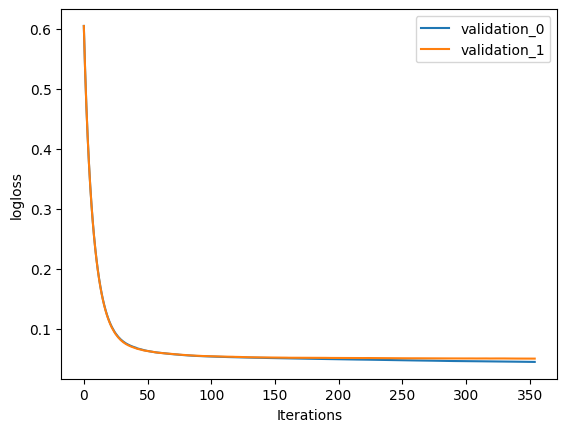

In [528]:
def printConfusionMatrix(): # Confusion Matrix
    metrics.ConfusionMatrixDisplay.from_estimator(model, xtest, ytest, cmap='Blues')
    pyplot.show()

def plotLossCurves():       # Loss Curves
    # save evaluation results
    results = model.evals_result()
    # plot curves
    lossValue = list(results['validation_1'])[0]
    pyplot.plot(results['validation_0'][lossValue], label='train')
    pyplot.plot(results['validation_1'][lossValue], label='train')
    # show the legend
    pyplot.xlabel('Iterations')
    pyplot.ylabel('Log Loss')
    pyplot.legend()
    # show the plot
    pyplot.show()

def printClassReport():     # Classification Report
    # Report
    print(metrics.classification_report(ytest, yhat, digits = 3))

def printMisc():            # Best Iter, Test Accuracy, Base Score, Probas,
    # Misc
    print(f'# Trees / Best Iteration: \t{bIter}')
    print(f'Test Accuracy: \t{accuracy_score(ytest, yhat)}')
    print(f'Base_Score{model.base_score}')
    print(f'\nPredict_Proba Return: \n{model.predict_proba(xtest)}')

def dynLossCurves(model):
    results = model.evals_result()
    names = list(model.evals_result())
    lossValue = list(results[names[0]])[0]
    for i in names:
        pyplot.plot(results[i][lossValue], label=i)
    pyplot.ylabel(lossValue)
    pyplot.xlabel('Iterations')
    pyplot.legend()
    pyplot.show()

dynLossCurves(model)

#### Porting the Model to C

In [529]:
def portToC(model):
    import m2cgen as m2c

    with open('../exports/gyroExport.c','w') as f:
        code = m2c.export_to_c(model)
        f.write(code)

    print('Model exported to: "arduino-xgboost/exports/gyroExport.c"')

#### genInfer(): Generating Code for Lazy People

In [530]:
def genInfer(start=0, size=500, csv=True, float=True):
    start = start
    size = size
    length = 2
    
    # Declaring function
    print(f'void infer(int time, int csv) {{')

    # Printing Header
    print(f'\tif(csv==1){{')
    print(f'\t\tSerial.println("aScore0,aScore1");        // Printing header to name columns in csv')
    print(f'\t}} else {{')
    print(f'\t\tSerial.println("Start: {start} | End: {start+size}");    // Printing Range:')
    print(f'\t}}')

    print(f'\t// Declarations:')
    print(f'\tint length = {length};')
    if float == True:
        print(f'\tfloat result[length];')
    else:
        print(f'\tdouble result[length];')

    print(f'\t// Model Inference')
    for x in range(start,(start+size)):  
        if float == True:
            print(f'\tfloat x_{x}[] = {{' , end="")    
        else:
            print(f'\tdouble x_{x}[] = {{' , end="")
        features = xtest.values[x]
        for i in range(len(features)):
            if i < (len(features)-1):
                print(features[i], end=", ")
            else:
                print(features[i], end="};\n")
        print(f'\tint y_{x} = {yhat[x]};')
        print(f'\tscore(x_{x}, result);')
        if csv == True:
            print(f'\tprintScoreCSV(result, length, y_{x});')
        else:
            print(f'\tprintScoreCompare(result, length, y_{x});')
        
        print(f'\tdelay(time);\n')
    print(f'}}')

#### Generating Inference Data

In [531]:
def generateProbDF(localCapture=model,features_test=xtest):
    xtestlist = localCapture.predict_proba(features_test).tolist()
    list1 = []
    list2 = []

    for x in xtestlist:
        list1.append(round(x[0],4))
        list2.append(round(x[1],4))

    probDF = pd.DataFrame({
        'Label': localCapture.predict(features_test),
        'Prob0': list1,
        'Prob1': list2
    })
    return(probDF)

def exportProbDF(probDF = generateProbDF()):
    probDF.to_csv(datasetsPath + 'baseCapture.csv')

def importInoCapture():
    serial = pd.read_csv(datasetsPath + 'inoCapture.csv')
    serial = serial.truncate(after=(len(serial)-2)) # get rid of ##### REPEATING... #####
    return(serial)

def generateComparison(probDF=generateProbDF(),inoCapture=importInoCapture()):
    probDF = probDF.truncate(after=(len(inoCapture)-1))
    probDF = probDF.join(inoCapture)
    probDF.to_csv(datasetsPath + 'compareCaptures.csv')

### <ins>Main</ins>

#### Inspecting Dataset

In [532]:
# print(f'{gyro.head()}\n')       # Looking into basic structure
# printSummaryStatistics()

#### Evaluation Metrics

In [533]:
# printConfusionMatrix()
# plotLossCurves()
# printClassReport()
# printMisc()

#### Code Generation

In [534]:
# genInfer(start=0, size=500, csv=True, float=False)

#### Generate C-Port

In [535]:
# portToC(model)

#### Generate Inference Data and Comparison

In [536]:
# generateProbDF()      # params: localCapture (model to capture data from), features_test
# exportProbDF()        # params: probDF (probDF export)
# importInoCapture()    
# generateComparison()  # params: probDF, inoCapture

#### Sorted Feature Importances:

In [537]:
def getFeatureImportances(model: XGBClassifier, prints: bool = False) -> list:
    featurenames  = [str(i) for i in list(model.feature_names_in_)]
    importances = [float(i) for i in list(model.feature_importances_)]

    namedimportances = list(zip(importances, featurenames))

    namedimportances = sorted(namedimportances, key=lambda x: x[0], reverse=True)

    if prints == True:
        i = 1
        for feature in namedimportances:
            print(f'{i}. {feature[1]}: \t{feature[0]}')
            i += 1

    return(namedimportances)


featurenames  = [str(i) for i in list(model.feature_names_in_)]
importances = [float(i) for i in list(model.feature_importances_)]

namedimportances = list(zip(importances, featurenames))

namedimportances = sorted(namedimportances, key=lambda x: x[0], reverse=True)

ranking = getFeatureImportances(model, True)


1. accY: 	0.27228572964668274
2. accX: 	0.253284215927124
3. accZ: 	0.23500166833400726
4. gyroX: 	0.09213785827159882
5. gyroZ: 	0.08036712557077408
6. gyroY: 	0.06692343205213547


#### ROC / AUC


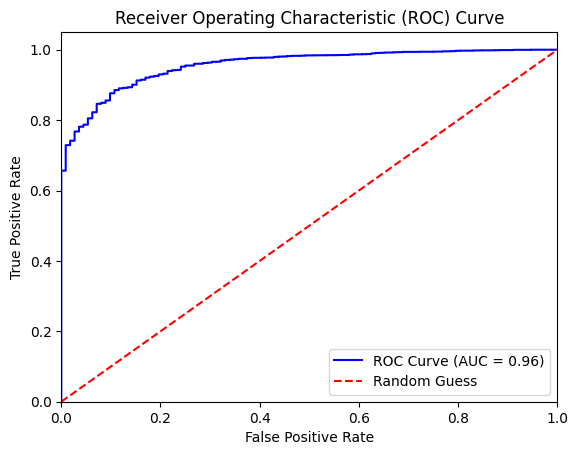

In [ ]:
def getAUC(model: XGBClassifier, ytest) -> None:
    # Get probability predictions
    yhat_proba = model.predict_proba(xtest)[:, 1]
    
    # Get false positive rate, true positive rate and thresholds
    fpr, tpr, thresholds = metrics.roc_curve(ytest, yhat_proba)
    
    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC Curve
    # pyplot.figure(figsize=(8,6))
    pyplot.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    pyplot.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
    pyplot.xlim([0.0, 1.0])
    pyplot.ylim([0.0, 1.05])
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title('Receiver Operating Characteristic (ROC) Curve')
    pyplot.legend(loc="lower right")
    pyplot.show()

getAUC(model, ytest)